In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ks_2samp
import pandas as pd 
from scipy.stats import wasserstein_distance

dynamics_feat = {
    'GNM_Ventropy_full': r'Entropy$_v$', 'GNM_rmsf_overall_full': r'RMSF$_{all}$', 
    'GNM_Eigval1_full': r'$\lambda_1$', 'GNM_Eigval2_full': r'$\lambda_2$',
    'GNM_Eigval5_1_full': r'$\lambda_{5-1}$', 'GNM_SEall_full': r'SE$_{all}$',
    'GNM_SE20_full': r'SE$_{20}$', 'GNM_V1_full': r'$‖V_{1,i}‖$',
    'GNM_rankV1_full': r'rank ($‖V_{1,i}‖$)', 'GNM_V2_full': r'$‖V_{2,i}‖$',
    'GNM_rankV2_full': r'rank ($‖V_{2,i}‖$)', 'GNM_co_rank_full': r'rank ($‖C_{i,i}‖$)',
    'GNM_displacement_full': r'$‖C_{i,i}‖$', 'GNM_MC1_full': r'MC${_1}$',
    'GNM_MC2_full': r'MC${_2}$', 'ANM_effectiveness_chain': r'Effectiveness$^*$',
    'ANM_sensitivity_chain': r'Sensitivity$^*$',
    'ANM_stiffness_chain': r'Stiffness$^*$'
    # 'wtBJCE': r'wtBJCE', 'deltaBJCE': r'$\Delta$BJCE'
}
structure_feat = {
    'chain_length': r'Protein Size', 
    'Rg': r'R$_g$', 'DELTA_Rg': r'$\Delta$R$_g$',
    'AG1': r'AG$_1$', 'AG3': r'AG$_3$', 'AG5': r'AG$_5$', 
    'ACR': r'ACR', 'DELTA_ACR': r'$\Delta$ACR',
    'SF1': r'SF$_1$', 'SF2': r'SF$_2$', 'SF3': r'SF$_3$',
    'loop_percent': r'%Loop', 'helix_percent': r'%Helix', 'sheet_percent': r'%Sheet',
    'Lside': r'L$_{side}$', 'deltaLside': r'$\Delta$L$_{side}$', # not availabel yet
    'IDRs': r'Disorderliness', 'dssp': r'DSSP', 'Dcom': r'D$_{com}$', 
    'SASA': r'SA', 'DELTA_SASA': r'$\Delta$SA', 
    'Hbond': r'N$_{H-bond}$', 'DELTA_Hbond': r'$\Delta$N$_{H-bond}$',
    'SSbond': r'N$_{SS-bond}$', 'DELTA_DSS': r'$\Delta$N$_{SS-bond}$',
}
seq_feat = {
    'wtPSIC': r'wtPSIC$^*$', 'deltaPSIC': r'$\Delta$PSIC$^*$', 
    'BLOSUM': r'BLOSUM$^*$', 'entropy': r'Entropy$^*$', 'ranked_MI': r'Ranked MI$^*$',
    'consurf': r'ConSurf', 'ACNR': r'ACNR',
    'phobic_percent': r'%Hydrophobic', 'delta_phobic_percent': r'$\Delta$%Hydrophobic',
    'philic_percent': r'%Hydrophilic', 'delta_philic_percent': r'$\Delta$%Hydrophilic',
    'charge': r'Charge', 'deltaCharge': r'$\Delta$Charge', 
    'polarity': r'Polarity', 'deltaPolarity': r'$\Delta$Polarity', 
    'charge_pH7': r'Charge$_{pH7}$', 'DELTA_charge_pH7': r'$\Delta$Charge$_{pH7}$',
}
cols = {**dynamics_feat, **structure_feat, **seq_feat}
print(len(dynamics_feat), len(structure_feat), len(seq_feat))
print(len(cols))

def plot_feature(df, feat_name, folder='.'):
    plt.figure(figsize=(9, 6))
    # Normalize the feature
    _pos = df[df['labels'] == 1][feat_name].values
    _neg = df[df['labels'] == 0][feat_name].values

    _pos = _pos[~pd.isnull(_pos)]
    _neg = _neg[~pd.isnull(_neg)]

    _pos_mean, _neg_mean = _pos.mean(), _neg.mean()
    _pos_std, _neg_std = _pos.std(), _neg.std()
    _pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

    w_dist = wasserstein_distance(
        (_pos - df[feat_name].mean()) / df[feat_name].std(),
        (_neg - df[feat_name].mean()) / df[feat_name].std()
    )
    t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
    KS_stat, KS_p_val = ks_2samp(_pos, _neg)
    if p_val <= 10**(-300):
        p_val = '≤1e-300'
    else:
        p_val = f'{p_val:.2e}'
    if KS_p_val <= 10**(-300):
        KS_p_val = '≤1e-300'
    else:
        KS_p_val = f'{KS_p_val:.2e}'
    txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

    _pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
    _neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
    sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
    sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
    plt.title(f'{cols[feat_name]}', fontsize=25)
    plt.xlabel('Value', fontsize=25)
    plt.ylabel('Probability', fontsize=25)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    legend = plt.legend(fontsize=15)

    # # Plot the text below the legend
    bbox = legend.get_window_extent()  # Bounding box in display space
    ax = plt.gca()  # Current axis
    bbox_axes = ax.transAxes.inverted().transform(bbox)
    # x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
    x_legend = bbox_axes[0][0]  # Left x-coordinate
    y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
    # Plot the text below the legend
    lines = txt_msg.split('\n')
    line_spacing = 0.06  # Try tuning this value
    for i, line in enumerate(lines):
        plt.text(x_legend, y_legend - i * line_spacing, line,
                fontsize=15, transform=plt.gca().transAxes, ha='left')
        # plt.text(x_legend+0.03, y_legend - i * line_spacing, line,
        #         fontsize=15, transform=plt.gca().transAxes, ha='left')
    # plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    print(f"{feat_name} is saved at {folder}/{feat_name}.png")
    plt.close()

def split_plot(df, feat_name, 
               ax1_ylim=None, ax2_ylim=None, 
               ax1_yticks=None, ax2_yticks=None,
               folder='.'):
    _pos = df[df['labels'] == 1][feat_name].values
    _neg = df[df['labels'] == 0][feat_name].values

    _pos = _pos[~pd.isnull(_pos)]
    _neg = _neg[~pd.isnull(_neg)]

    _pos_mean, _neg_mean = _pos.mean(), _neg.mean()
    _pos_std, _neg_std = _pos.std(), _neg.std()
    _pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))
    _pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
    _neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'

    w_dist = wasserstein_distance(
        (_pos - df[feat_name].mean()) / df[feat_name].std(),
        (_neg - df[feat_name].mean()) / df[feat_name].std()
    )
    t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
    KS_stat, KS_p_val = ks_2samp(_pos, _neg)
    if p_val <= 10**(-300):
        p_val = '≤1e-300'
    else:
        p_val = f'{p_val:.2e}'
    if KS_p_val <= 10**(-300):
        KS_p_val = '≤1e-300'
    else:
        KS_p_val = f'{KS_p_val:.2e}'
    txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

    # Define the height ratios, for example, 1:2 (ax1 is 1 unit high, ax2 is 2 units high)
    # plt.figure(figsize=(9, 6))
    height_ratios = [1, 2]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': height_ratios},
                                figsize=(9, 6))
    # plot the same data on both Axes: n_SAVs_per_UniProtID
    sns.histplot(_pos, bins=50, color='r', alpha=0.5, kde=False, ax=ax1, stat='probability', label=f'Pathogenic, {_pos_text}')
    sns.histplot(_pos, bins=50, color='r', alpha=0.5, kde=False, ax=ax2, stat='probability')

    sns.histplot(_neg, bins=50, color='b', alpha=0.5, kde=False, ax=ax1, stat='probability', label=f'Benign, {_neg_text}')
    sns.histplot(_neg, bins=50, color='b', alpha=0.5, kde=False, ax=ax2, stat='probability')

    # y-axis limits
    if ax1_ylim is not None:
        ax1.set_ylim(ax1_ylim)
    if ax2_ylim is not None:
        ax2.set_ylim(ax2_ylim)
    # y-axis sticks
    if ax1_yticks is not None:
        ax1.set_yticks(ax1_yticks)
    if ax2_yticks is not None:
        ax2.set_yticks(ax2_yticks)
    # Font size of x-axis and y-axis
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)
    # Hide the spines between ax1 and ax2
    ax1.spines.bottom.set_visible(False)
    ax1.spines.top.set_visible(False)
    ax1.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.spines.right.set_visible(False)
    # remove ticks of ax1
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # Set y-title for both ax1 and ax2 as Probability, but only show once for both
    # The tile should be in the middle of the two subplots
    ax1.set_ylabel('', fontsize=15)
    ax2.set_ylabel('Probability', fontsize=25)
    ax2.yaxis.set_label_coords(-0.12, 0.9)
    ax1.set_title(f'{cols[feat_name]}', fontsize=25)
    ax2.set_xlabel('Value', fontsize=25)
    # plt.title(f'{feat_name}', fontsize=25)
    # Draw the slanted lines
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0], transform=ax1.transAxes, **kwargs)
    ax2.plot([1], transform=ax2.transAxes, **kwargs)

    # Plot legend
    legend = ax1.legend(fontsize=15)
    # Plot the text below the legend
    bbox = legend.get_window_extent()  # Bounding box in display space
    ax = plt.gca()  # Current axis
    bbox_axes = ax.transAxes.inverted().transform(bbox)
    x_legend = bbox_axes[0][0]  # Left x-coordinate
    y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
    # Plot the text below the legend
    lines = txt_msg.split('\n')
    line_spacing = 0.1  # Try tuning this value
    for i, line in enumerate(lines):
        plt.text(x_legend, y_legend - i * line_spacing, line,
                fontsize=15, transform=plt.gca().transAxes, ha='left')
    plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    print(f"{feat_name} is saved at {folder}/{feat_name}.png")
    plt.close()

# cols = {k: v for k, v in cols.items() if k in df.columns}
# df = pd.read_csv('features_withNEWpfam_25Mar26.csv')
df = pd.read_csv('/mnt/nas_1/YangLab/loci/tandem/data/R20000/final_features.csv')
# df = df.rename(columns=cols)

# df[df['BLOSUM'].isna()][feats]
# # SAV_coords,entropy,ranked_MI,wtPSIC,deltaPSIC,BLOSUM,phobic_percent,delta_phobic_percent,charge,deltaCharge,polarity,deltaPolarity
# # P04745 378 D N, , ,-2.426 ,-0.1 ,1.0,55.959594,0.0,1.0,-1.0,13.0,-1.4
# # P04745 411 N I,,,-2.95,-1.04,-3.0,55.959594,0.0,0.0,0.0,11.6,-6.4

# df.loc[df['SAV_coords']=='P04745 378 D N', 'BLOSUM'] = 1
# df.loc[df['SAV_coords']=='P04745 378 D N', 'phobic_percent'] = 55.959594
# df.loc[df['SAV_coords']=='P04745 378 D N', 'delta_phobic_percent'] = 0.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'charge'] = 1.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'deltaCharge'] = -1.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'polarity'] = 13.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'deltaPolarity'] = -1.4
# df.loc[df['SAV_coords']=='P04745 378 D N', 'philic_percent'] = 100 - 55.959594
# df.loc[df['SAV_coords']=='P04745 378 D N', 'delta_philic_percent'] = 0.0

# df.loc[df['SAV_coords']=='P04745 411 N I', 'BLOSUM'] = -3
# df.loc[df['SAV_coords']=='P04745 411 N I', 'phobic_percent'] = 55.959594
# df.loc[df['SAV_coords']=='P04745 411 N I', 'delta_phobic_percent'] = 0.0
# df.loc[df['SAV_coords']=='P04745 411 N I', 'charge'] = 0.0
# df.loc[df['SAV_coords']=='P04745 411 N I', 'deltaCharge'] = 0.0
# df.loc[df['SAV_coords']=='P04745 411 N I', 'polarity'] = 11.6
# df.loc[df['SAV_coords']=='P04745 411 N I', 'deltaPolarity'] = -6.4
# df.loc[df['SAV_coords']=='P04745 411 N I', 'philic_percent'] = 100 - 55.959594
# df.loc[df['SAV_coords']=='P04745 411 N I', 'delta_philic_percent'] = 0.0


18 25 17
60


# Rank_V1_full

In [ ]:
feat_name = 'GNM_rankV1_full'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 0.03)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
y_legend_top = bbox_axes[1][1] -0.02 # Top y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend-0.49, y_legend_top - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# Rank_V2_full

In [ ]:
feat_name = 'GNM_rankV2_full'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 0.033)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
y_legend_top = bbox_axes[1][1] -0.02 # Top y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend-0.49, y_legend_top - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# GNM_co_rank_full

In [ ]:
feat_name = 'GNM_co_rank_full'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 0.04)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
y_legend_top = bbox_axes[1][1] -0.02 # Top y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend-0.49, y_legend_top - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# Delta_BJCE

In [ ]:
feat_name = 'deltaBJCE'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend+0.03, y_legend - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# deltaLside

In [ ]:
feat_name = 'deltaLside'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.6, 1))

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend, y_legend - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# BLOSUM

In [ ]:
feat_name = 'BLOSUM'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-4, 4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.65, 1))

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend, y_legend - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# All features

In [199]:
from src.utils.settings import ROOT_DIR
savedir = f'{ROOT_DIR}/data/R20000/stats'
feat = 'chain_length'
plot_feature(df, feat, folder=savedir)

chain_length is saved at /mnt/nas_1/YangLab/loci/tandem/data/R20000/stats/chain_length.png


In [ ]:
from src.utils.settings import ROOT_DIR
savedir = f'{ROOT_DIR}/data/R20000/stats'
feat = 'BLOSUM,phobic_percent,delta_phobic_percent,philic_percent,delta_philic_percent,charge,deltaCharge,polarity,deltaPolarity'.split(',')
for f in feat:
    plot_feature(df, f, folder=savedir)
# for feat in cols.keys():
#     if feat == 'SF3':
#         plot_feature(df, feat, folder=savedir)

# feat_name = 'ANM_effectiveness_chain'
# split_plot(df, feat_name, ax1_ylim=(0.9, 1), ax2_ylim=(0, 0.03), 
#            ax1_yticks=[0.9, 0.95, 1], ax2_yticks=[0, 0.01, 0.02, 0.03],
#            folder=savedir)
# feat_name = 'GNM_MC2_full'
# split_plot(df, feat_name, ax1_ylim=(0.7, 1), ax2_ylim=(0, 0.15), 
#            ax1_yticks=[0.7, 0.8, 0.9, 1],
#            ax2_yticks=[0, 0.05, 0.1, 0.15],
#            folder=savedir)
# feat_name = 'GNM_MC1_full'
# split_plot(df, feat_name, ax1_ylim=(0.7, 1), ax2_ylim=(0, 0.1), folder=savedir)
# feat_name = 'ANM_sensitivity_chain'
# split_plot(df, feat_name, ax1_ylim=(0.9, 1), ax2_ylim=(0, 0.01), folder=savedir)
# feat_name = 'DELTA_Rg'
# split_plot(df, feat_name, ax1_ylim=(0.9, 1), ax2_ylim=(0, 0.001), folder=savedir)


# Feature correlations

Text(52, -9, 'Sequence & Chemical')

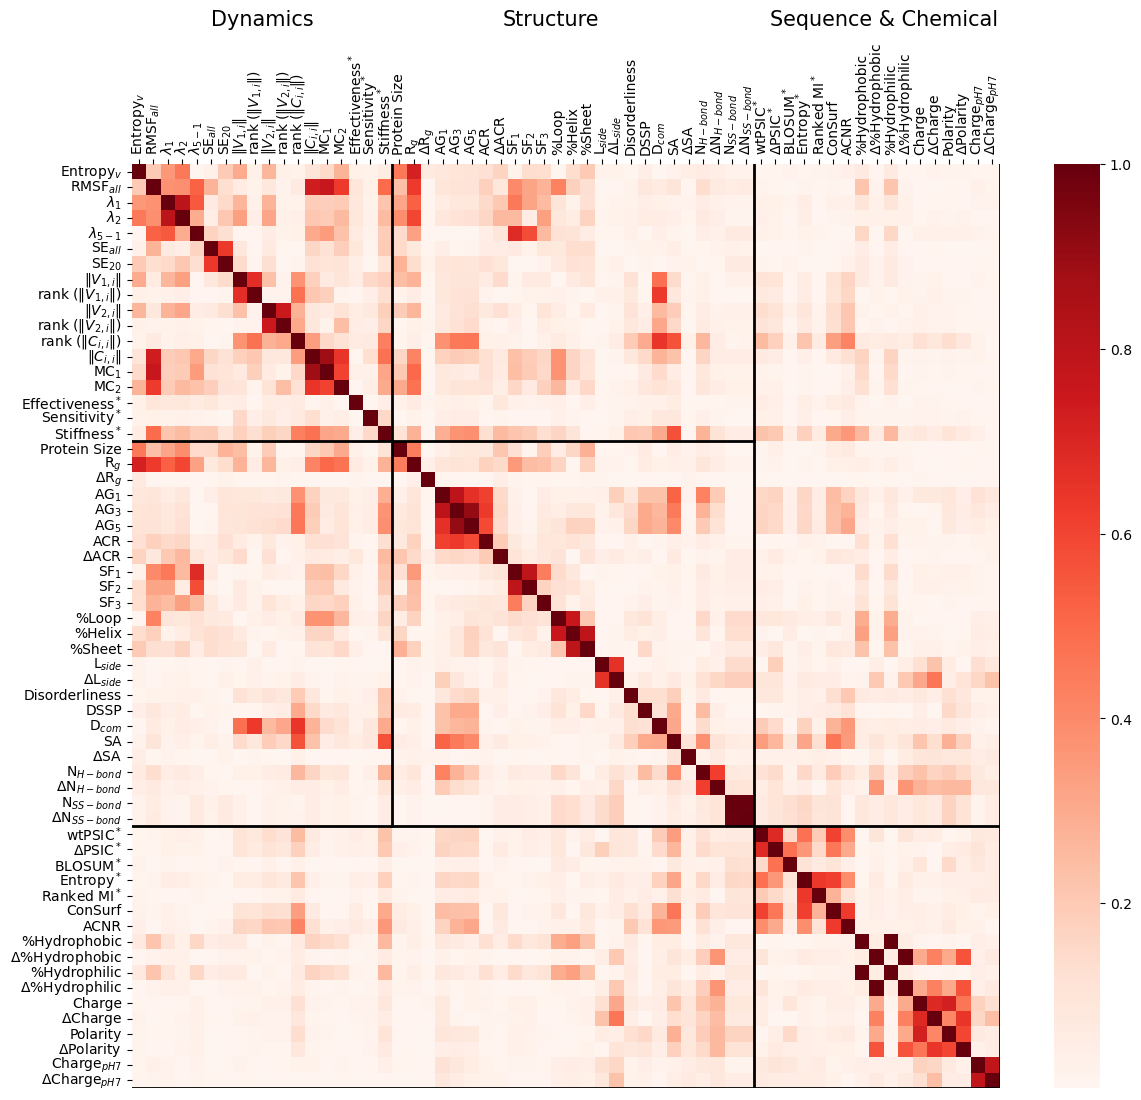

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Choose columns 3 to end
feat = df.iloc[:, 2:]
feat = feat[cols.keys()]
feat = feat.rename(columns=cols)
cor = feat.corr(method='pearson', numeric_only=True)
# Turn to absolute correlation values
cor = cor.abs()
plt.figure(figsize=(14, 12))
# Create heatmap with feature names on top and left
ax = sns.heatmap(cor, annot=False, cmap=plt.cm.Reds, xticklabels=cor.columns, yticklabels=cor.columns)
# ax.set(xlabel='', ylabel='')
ax.xaxis.tick_top()# and vertical lines
plt.xticks(rotation=90)


n_dynamics = len(dynamics_feat)
n_structure = len(structure_feat)
n_seq = len(seq_feat)
n_feat = n_dynamics + n_structure + n_seq

# Dynamics features
plt.axhline(y=n_dynamics, xmin = 0, xmax = (n_dynamics+n_structure) / n_feat, color='black', linewidth=2)
plt.axvline(x=n_dynamics, ymin=(n_feat-n_dynamics-n_structure) / n_feat, ymax=1, color='black', linewidth=2)
plt.text(9, -9, 'Dynamics', fontsize=15, ha='center')

# Structure features
plt.axhline(y=n_dynamics+n_structure, xmin=0, xmax=(n_dynamics+n_structure+n_seq) / n_feat, color='black', linewidth=2)
plt.axvline(x=n_dynamics+n_structure    , ymin=(n_feat-n_dynamics-n_structure-n_seq) / n_feat, ymax=1, color='black', linewidth=2)
plt.text(11+n_dynamics, -9, 'Structure', fontsize=15, ha='center')

# # SEQ features
plt.axhline(y=n_dynamics+n_structure+n_seq, xmin=0, xmax=(n_dynamics+n_structure+n_seq) / n_feat, color='black', linewidth=2)
plt.axvline(x=n_dynamics+n_structure+n_seq, ymin=(n_feat-n_dynamics-n_structure-n_seq) / n_feat, ymax=1, color='black', linewidth=2)
plt.text(9+n_dynamics+n_structure, -9, 'Sequence & Chemical', fontsize=15, ha='center')

# Make sure the plot is in the center and not let labels/text outward
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# SAVe
# savdir = f'{ROOT_DIR}/data/R20000/stats'
# plt.savefig(f'{savdir}/feature_correlation.png')
# print(f"Feature correlation is saved at {savdir}/feature_correlation.png")
# plt.close()
# plt.show()


In [7]:
ranked_corr = cor.unstack().sort_values(ascending=False).drop_duplicates()
# ranked_corr = cor.unstack().sort_values(ascending=False)
print(ranked_corr[ranked_corr > 0.7].__len__() / ranked_corr.__len__())

print('Top highly correlated features:')
for i, (idx, value) in enumerate(ranked_corr.items()):
    print(f'{i+1}. {idx} - {value:.3f}')

0.009340338587273789
Top highly correlated features:
1. ('%Hydrophobic', '%Hydrophilic') - 1.000
2. ('Entropy$_v$', 'Entropy$_v$') - 1.000
3. ('N$_{SS-bond}$', '$\\Delta$N$_{SS-bond}$') - 0.996
4. ('AG$_3$', 'AG$_5$') - 0.910
5. ('$‖C_{i,i}‖$', 'MC${_1}$') - 0.883
6. ('$\\lambda_1$', '$\\lambda_2$') - 0.804
7. ('AG$_1$', 'AG$_3$') - 0.798
8. ('SF$_1$', 'SF$_2$') - 0.796
9. ('%Sheet', '%Helix') - 0.796
10. ('Charge$_{pH7}$', '$\\Delta$Charge$_{pH7}$') - 0.787
11. ('MC${_1}$', 'RMSF$_{all}$') - 0.761
12. ('%Helix', '%Loop') - 0.761
13. ('rank ($‖V_{2,i}‖$)', '$‖V_{2,i}‖$') - 0.752
14. ('$‖C_{i,i}‖$', 'RMSF$_{all}$') - 0.737
15. ('Charge', 'Polarity') - 0.726
16. ('R$_g$', 'Entropy$_v$') - 0.720
17. ('$\\Delta$Charge', 'Charge') - 0.690
18. ('$\\Delta$PSIC$^*$', 'wtPSIC$^*$') - 0.686
19. ('SF$_1$', '$\\lambda_{5-1}$') - 0.681
20. ('rank ($‖V_{1,i}‖$)', '$‖V_{1,i}‖$') - 0.670
21. ('AG$_5$', 'AG$_1$') - 0.663
22. ('$\\Delta$L$_{side}$', 'L$_{side}$') - 0.659
23. ('$\\Delta$Polarity', '$\\De

In [8]:
18/1713

0.010507880910683012

In [ ]:
# Features with high correlation
cutoff = 0.95
high_corr = cor[cor > cutoff]
print('Highly correlated features:')
for i, (idx, value) in enumerate(high_corr.unstack().sort_values(ascending=False).drop_duplicates().items()):
    if value > cutoff:
        print(f'{i+1}. {idx} - {value:.3f}')


# Rank features

In [4]:
from src.utils.settings import ROOT_DIR
import os 
import pandas as pd 
from prody import LOGGER
LOGGER.start(f'{ROOT_DIR}/data/R20000/stats/log.txt')
feat_path = os.path.join(ROOT_DIR, 'data/R20000/final_features.csv')
df = pd.read_csv(feat_path)
sel_cols = ['SAV_coords', 'labels'] + list(cols.keys())
df = df[sel_cols]
# df = df.rename(columns=cols)

# Remove features 
remove_feats = ['philic_percent', 'delta_philic_percent', 'GNM_Ventropy_full', 'DELTA_DSS']
for feat in remove_feats:
    if feat in df.columns:
        df = df.drop(columns=[feat])
        LOGGER.info(f'{feat} is removed from the dataframe')
    else:
        LOGGER.info(f'{feat} is not in the dataframe')


from scipy import stats
import numpy as np
from scipy.stats import wasserstein_distance
import numpy as np

stats_cols = ['feature', 't-pvalue', 'K-S-pvalue', 'M-W_U_pvalue','wasserstein_distance']
data = []
for feat_name in df.columns[2:]:
    # Standardize the feature
    fmean = df[feat_name].mean()
    fstd = df[feat_name].std()
    df[feat_name] = (df[feat_name] - fmean) / fstd

    # Retrieve the positive and negative samples
    pos = df[df['labels'] == 1][feat_name].values
    neg = df[df['labels'] == 0][feat_name].values
    pos = pos[~pd.isnull(pos)]
    neg = neg[~pd.isnull(neg)]

    t_test = stats.ttest_ind(pos, neg, equal_var=True)
    ks_test = stats.ks_2samp(pos, neg)
    mannwhitneyu_test = stats.mannwhitneyu(pos, neg)
    wasserstein = wasserstein_distance(pos, neg)
    data.append([feat_name, t_test.pvalue, ks_test.pvalue, mannwhitneyu_test.pvalue, wasserstein])

# Create a dataframe to store the statistics
df_stats = pd.DataFrame(data, columns=stats_cols)
# Rank the features based on the p-values
df_stats['ttest_rank'] = df_stats['t-pvalue'].rank()
df_stats['KStest_rank'] = df_stats['K-S-pvalue'].rank()
df_stats['MWUtest_rank'] = df_stats['M-W_U_pvalue'].rank()
df_stats['wasserstein_dist_rank'] = df_stats['wasserstein_distance'].rank(ascending=False)

##### Take the first 33 features based on the t-test ranking
t_sel_feats = df_stats.sort_values('ttest_rank').head(33)['feature'].values
t_sel_DYNfeats = [feat for feat in t_sel_feats if feat in dynamics_feat.keys()]
t_sel_STRfeats = [feat for feat in t_sel_feats if feat in structure_feat.keys()]
t_set_SEQfeats = [feat for feat in t_sel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the t-test ranking:')
LOGGER.info(f'{len(t_sel_DYNfeats)} Dynamics features: {t_sel_DYNfeats}')
LOGGER.info(f'{len(t_sel_STRfeats)} Structure features: {t_sel_STRfeats}')
LOGGER.info(f'{len(t_set_SEQfeats)} Sequence features: {t_set_SEQfeats}')

##### Take the first 33 features based on the wasserstein_dist_rank ranking
w_sel_feats = df_stats.sort_values('wasserstein_dist_rank').head(33)['feature'].values
w_sel_DYNfeats = [feat for feat in w_sel_feats if feat in dynamics_feat.keys()]
w_sel_STRfeats = [feat for feat in w_sel_feats if feat in structure_feat.keys()]
w_set_SEQfeats = [feat for feat in w_sel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the wasserstein_dist_rank ranking:')
LOGGER.info(f'{len(w_sel_DYNfeats)} Dynamics features: {w_sel_DYNfeats}')
LOGGER.info(f'{len(w_sel_STRfeats)} Structure features: {w_sel_STRfeats}')
LOGGER.info(f'{len(w_set_SEQfeats)} Sequence features: {w_set_SEQfeats}')

# Sum the rank of ttest_rank and washstein_dist_rank
df_stats['sum_rank_ttestANDwasserstein'] = df_stats['ttest_rank'] + df_stats['wasserstein_dist_rank']
##### Take the first 33 features based on the sum_rank_ttestANDwasserstein ranking
tWstsel_feats = df_stats.sort_values('sum_rank_ttestANDwasserstein').head(33)['feature'].values
tWstsel_DYNfeats = [feat for feat in tWstsel_feats if feat in dynamics_feat.keys()]
tWstsel_STRfeats = [feat for feat in tWstsel_feats if feat in structure_feat.keys()]
tWstsel_SEQfeats = [feat for feat in tWstsel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the sum_rank_ttestANDwasserstein ranking:')
LOGGER.info(f'{len(tWstsel_DYNfeats)} Dynamics features: {tWstsel_DYNfeats}')
LOGGER.info(f'{len(tWstsel_STRfeats)} Structure features: {tWstsel_STRfeats}')
LOGGER.info(f'{len(tWstsel_SEQfeats)} Sequence features: {tWstsel_SEQfeats}')

# Sum rank of ttest_rank and KStest_rank
df_stats['sum_rank_ttestANDKStest'] = df_stats['ttest_rank'] + df_stats['KStest_rank']
##### Take the first 33 features based on the sum_rank_ttestANDKStest ranking
tKS_sel_feats = df_stats.sort_values('sum_rank_ttestANDKStest').head(33)['feature'].values
tKS_sel_DYNfeats = [feat for feat in tKS_sel_feats if feat in dynamics_feat.keys()]
tKS_sel_STRfeats = [feat for feat in tKS_sel_feats if feat in structure_feat.keys()]
tKS_sel_SEQfeats = [feat for feat in tKS_sel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the sum_rank_ttestANDKStest ranking:')
LOGGER.info(f'{len(tKS_sel_DYNfeats)} Dynamics features: {tKS_sel_DYNfeats}')
LOGGER.info(f'{len(tKS_sel_STRfeats)} Structure features: {tKS_sel_STRfeats}')
LOGGER.info(f'{len(tKS_sel_SEQfeats)} Sequence features: {tKS_sel_SEQfeats}')
# Save the statistics to a CSV file
df_stats = df_stats.sort_values(by='ttest_rank', ascending=True)
df_stats.to_csv('data/R20000/stats/features_stats.csv', index=False)



@> Logging into file: /mnt/nas_1/YangLab/loci/tandem/data/R20000/stats/log.txt
@> Logging started at 2025-04-17 13:29:08.430235
@> philic_percent is removed from the dataframe
@> delta_philic_percent is removed from the dataframe
@> GNM_Ventropy_full is removed from the dataframe
@> DELTA_DSS is removed from the dataframe
@> # Top 33 features based on the t-test ranking:
@> 9 Dynamics features: ['GNM_co_rank_full', 'ANM_stiffness_chain', 'GNM_V2_full', 'GNM_V1_full', 'GNM_Eigval1_full', 'GNM_rankV2_full', 'GNM_Eigval2_full', 'GNM_rankV1_full', 'ANM_effectiveness_chain']
@> 15 Structure features: ['SASA', 'loop_percent', 'AG1', 'Dcom', 'AG5', 'AG3', 'SSbond', 'Hbond', 'DELTA_Hbond', 'sheet_percent', 'helix_percent', 'Rg', 'IDRs', 'Lside', 'deltaLside']
@> 9 Sequence features: ['entropy', 'wtPSIC', 'deltaPSIC', 'consurf', 'ACNR', 'BLOSUM', 'ranked_MI', 'deltaPolarity', 'deltaCharge']
@> # Top 33 features based on the wasserstein_dist_rank ranking:
@> 8 Dynamics features: ['ANM_stiffness_

In [207]:
set(tKS_sel_feats) - set(['ANM_stiffness_chain', 'GNM_co_rank_full', 'GNM_V2_full', 'GNM_V1_full', 'GNM_Eigval1_full', 'GNM_Eigval2_full', 'wtBJCE', 'GNM_rankV2_full', 'deltaBJCE', 'GNM_displacement_full', 'ANM_effectiveness_chain', 'SASA', 'loop_percent', 'AG5', 'AG3', 'AG1', 'Dcom', 'Rg', 'sheet_percent', 'DELTA_Hbond', 'deltaLside', 'Hbond', 'helix_percent', 'deltaPSIC', 'wtPSIC', 'consurf', 'entropy', 'ACNR', 'BLOSUM', 'ranked_MI', 'deltaPolarity', 'phobic_percent'])

{'chain_length'}

In [211]:
tKS_sel_STRfeats

df_stats = pd.read_csv('data/R20000/stats/features_stats.csv')
t_sel_feats = df_stats.sort_values('sum_rank_ttestANDKStest').head(33)['feature'].values
sel_DYNfeats = [feat for feat in t_sel_feats if feat in dynamics_feat.keys()]
sel_STRfeats = [feat for feat in t_sel_feats if feat in structure_feat.keys()]
sel_SEQfeats = [feat for feat in t_sel_feats if feat in seq_feat.keys()]
t_sel_feats = sel_DYNfeats + sel_STRfeats + sel_SEQfeats

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.patches as mpatches

# Create figure
plt.figure(figsize=(8, 6))

# Create 3-set Venn diagram with dummy subset sizes
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 5),
             set_labels=("T-test", "Wasserstein", "T-test+KS-test"))

"""
0 Only in T-test                        rank(‖V₁,i‖), IDRs, Lside, %Helix
1 Only in Wasserstein                   deltaACR, deltaCharge
2 Only in T-test+KS-test                Effectiveness, λ₅₋₁, ‖Cᵢ,i‖
3 In T-test and Wasserstein             N_ss-bond
4 In T-test and T-test+KS-test          empty
5 In Wasserstein and T-test+KS-test     Protein size, %hydrophobic
6 In all three                          Stiffness, 𝜆_1, 𝜆_2, ‖𝑉_(1,𝑖) ‖, ‖𝑉_(2,𝑖) ‖, rank(‖𝐶_(𝑖,𝑖) ‖), rank(‖𝑉_(2,𝑖) ‖), ΔBJCE, BJCE, AG1, AG3, AG5, ΔNH-bond, NH-bond, Dcom, Rg, SA, ΔLside, %Loop, %Sheet, ACRN, BLOSUM, ConSurf, ΔPSIC, ΔPolarity, Entropy, Ranked MI wtPSIC
"""
# Remove default labels
for subset in venn.subset_labels:
    if subset:
        subset.set_text("")

# Change set label font size
for label in venn.set_labels:
    label.set_fontsize(14)
    label.set_fontweight("bold")

# What is space in LaTeX?
# \space

features_latex = {
    '100': (
        r'$\mathrm{rank}(\|V_{1,i}\|)$' '\n'
        r'IDRs' '\n'
        r'Lside' '\n'
        r'%Helix'
    ),
    '010': (
        r'$\Delta$ACR' '\n'
        r'$\Delta$Charge'
    ),
    '001': (
        r'Effectiveness' ', '
        r'$\lambda_{5-1}$' ', '
        r'$\|C_{i,i}\|$'
    ),
    '110': r'$N_{\mathrm{ss-bond}}$',
    '011': "",  # fill later
    '101': "",  # fill later
    '111': (
        # DYN
        r'Stiffness, $\lambda_1$, $\lambda_2$' '\n'
        r'$\|V_{1,i}\|$, $\|V_{2,i}\|$' '\n'
        r'$\mathrm{rank}(\|C_{i,i}\|)$, $\mathrm{rank}(\|V_{2,i}\|)$' '\n'
        r'$\Delta$BJCE, BJCE' '\n'
        # STR
        r'$AG_1$, $AG_3$, $AG_5$' '\n'
        r'$\Delta N_{\mathrm{H-bond}}$, $N_{\mathrm{H-bond}}$' '\n'
        r'Dcom, Rg, SA' '\n'
        r'$\Delta L_{\mathrm{side}}$, %Loop, %Sheet' '\n'
        # SEQ
        r'ACRN, BLOSUM, ConSurf' '\n'
        r'$\Delta$PSIC, $\Delta$Polarity' '\n'
        r'Entropy, Ranked MI' '\n'
        r'wtPSIC'
    )
}

# Text colors per region
colors = {
    '100': 'green',
    '010': 'blue',
    '001': 'red',
    '110': 'black',
    '011': 'blue',
    '101': 'red',
    '111': 'black'
}

# Annotate regions
for region_code, text in features_latex.items():
    subset = venn.get_label_by_id(region_code)
    if subset:
        subset.set_text(text)
        subset.set_fontsize(10)
        # left align
        # subset.set_horizontalalignment('left')
        subset.set_color(colors[region_code])

# Add custom legend
# legend_patches = [
#     mpatches.Patch(color='red', label='Dynamics features'),
#     mpatches.Patch(color='blue', label='Sequence & chemical features'),
#     mpatches.Patch(color='green', label='Structure features')
# ]
# plt.legend(handles=legend_patches, loc='upper left', fontsize=12)

# Title
plt.title("Categorization of 62 Protein Features for SAVs", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

['SASA',
 'loop_percent',
 'AG5',
 'AG3',
 'AG1',
 'Dcom',
 'Rg',
 'sheet_percent',
 'DELTA_Hbond',
 'deltaLside',
 'chain_length',
 'Hbond',
 'helix_percent']